# Loading Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [82]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/train_clean_final.csv')

# Data Overview

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168389 entries, 0 to 3168388
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   BROWSE_NODE_ID  int64 
 1   CLEANED TEXT    object
dtypes: int64(1), object(1)
memory usage: 48.3+ MB


In [6]:
df.head()

,BROWSE_NODE_ID,CLEANED TEXT
0,0,cat blue doll inch cat popular cat new cat blu...
1,1,new refrigerator magnet new cello wrapped hard...
2,-1,ultimate self complete guide baking craft gard...
3,3,kid iron tablet kid iron tablet quantity tablet
4,4,teacher planner company lesson teacher planner...


In [7]:
df.isnull().sum()

BROWSE_NODE_ID       0
CLEANED TEXT      9161
dtype: int64

In [8]:
df.duplicated().sum()

835684

In [9]:
df.drop_duplicates(inplace=True)
print(df.isnull().sum())

BROWSE_NODE_ID      0
CLEANED TEXT      198
dtype: int64


In [10]:
df.dropna(inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2332507 entries, 0 to 3168386
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   BROWSE_NODE_ID  int64 
 1   CLEANED TEXT    object
dtypes: int64(1), object(1)
memory usage: 53.4+ MB


# Loading Corpus and other node id

In [12]:
with open('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/corpus.txt','r') as f:
  corpus = f.readline().split(',')[:-1]
  corpus = np.array(corpus)

print(len(corpus))
print(corpus[:10])

8138
['hardness' 'bulletin' 'splitter' 'mustard' 'heard' 'usually'
 'transferring' 'functional' 'tourmaline' 'court']


In [13]:
f = open('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/other_node_id.txt', 'r')

other_node_id = [int(i) for i in f.readline().split(',')[:-1]]

f.close()
print(other_node_id)

[15967, 3186, 15800, 8507, 31189, 12978, 32005, 588, 1386, 31871, 35508, 26655, 39381, 181727, 8846, 51359, 7331, 5347, 51174, 15698, 26940, 46786, 68849, 881, 8491, 16763, 1879, 31882, 22472, 25109, 40545, 22237, 420, 6035, 122852, 55588, 31956, 17956, 23117, 2467, 295, 85381, 11039, 10487, 46925, 78615, 103853, 59540, 8750, 17565, 18347, 450, 1831, 38762, 82027, 2830, 45510, 16720, 93129, 14776, 9103, 38214, 95704, 3699, 29897, 30003, 58087, 52086, 1245, 287, 7534, 363, 167904, 5418, 25573, 85585, 58783, 38176, 29856, 30478, 44409, 121775, 20705, 4527, 4493, 5067, 8198, 2121, 9496, 3097, 578, 3106, 7242, 102, 30642, 24074, 3255, 4135, 66550, 213026, 7057, 6653, 2408, 28876, 25444, 4372, 545, 15469, 15038, 39991, 51388, 32664, 138909, 107, 9766, 33225, 24813, 1993, 8722, 38562, 2577, 76398, 23925, 26398, 83642, 37520, 22996, 27486, 18298, 14905, 44828, 2547, 64855, 16919, 60488, 30062, 11921, 25094, 30520, 33368, 6983, 1737, 19341, 877, 6719, 78880, 31490, 47530, 102411, 551, 14768, 1

In [14]:
other_node_id = np.array(other_node_id)
len(other_node_id)

7160

In [57]:
#label encoding
le = LabelEncoder()
df['Encoded_BROWSE_NODE_ID'] = le.fit_transform(df['BROWSE_NODE_ID'])


In [58]:
le.classes_

array([    -1,      0,      1, ..., 166575, 215592, 267793])

In [59]:
df.head()

,BROWSE_NODE_ID,CLEANED TEXT,Encoded_BROWSE_NODE_ID
0,0,cat blue doll inch cat popular cat new cat blu...,1
1,1,new refrigerator magnet new cello wrapped hard...,2
2,-1,ultimate self complete guide baking craft gard...,0
3,3,kid iron tablet kid iron tablet quantity tablet,3
4,4,teacher planner company lesson teacher planner...,4


# Visualizing 

In [ ]:
unique, counts = np.unique(df['BROWSE_NODE_ID'], return_counts=True)

print(np.asarray((unique, counts)))

[[    -1      0      1 ... 166575 215592 267793]
 [128587   2685   1543 ...     81     75     64]]


In [ ]:
print(len(unique))

2760


In [ ]:
sort_index = np.argsort(-counts)
counts = counts[sort_index]
unique = unique[sort_index]

print(unique)
print(counts)

[ 1045    -1     5 ... 14156 44878  2788]
[139321 128587  52140 ...     54     50     18]


In [ ]:
cdf = np.cumsum(counts)
cdf = (cdf/len(df['BROWSE_NODE_ID']))*100
print(cdf)

[  5.9730153   11.48583906  13.72120212 ...  99.99708468  99.9992283
 100.        ]


In [ ]:
cdf_index = list(range(0,len(cdf)))

In [ ]:
np.argwhere(cdf>95)[0], np.argwhere(cdf>90)[0]

(array([1726]), array([1201]))

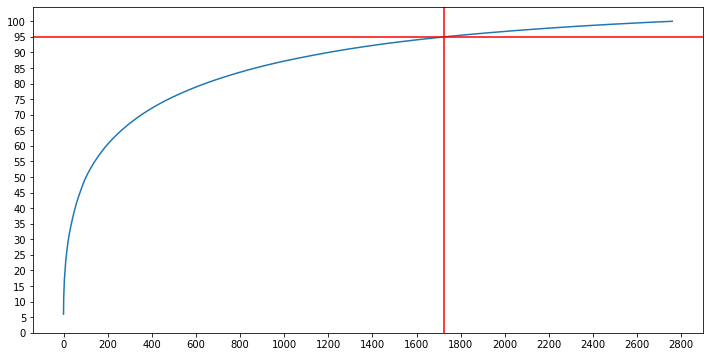

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(cdf_index,cdf)
plt.axhline(95, c='red')
plt.axvline(1726, c='red')
plt.yticks(np.arange(0,101,5))
plt.xticks(np.arange(0,3000,200))
plt.show()

In [ ]:
UNIQUE = [str(i) for i in unique]
print(len(UNIQUE))
print(UNIQUE[:5])

2760
['1045', '-1', '5', '1251', '1052']


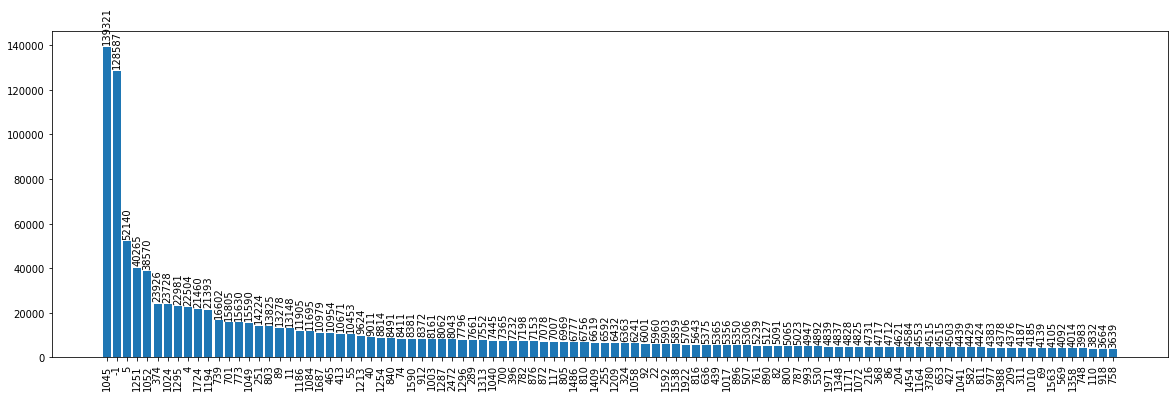

In [ ]:
plt.figure(figsize = (20,6))
plt.bar(UNIQUE[:100],counts[:100])
plt.xticks(rotation=90)

for index, value in enumerate(counts[:100]):
    plt.text(index, value+2000, str(value), horizontalalignment='center', rotation=90)

plt.show()

In [ ]:
unique

array([ 1045,    -1,     5, ..., 14156, 44878,  2788])

In [ ]:
np.log(unique)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


array([ 6.95177216,         nan,  1.60943791, ...,  9.55789384,
       10.71170298,  7.93307977])

In [ ]:
np.exp(np.log(unique))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


array([1.0450e+03,        nan, 5.0000e+00, ..., 1.4156e+04, 4.4878e+04,
       2.7880e+03])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


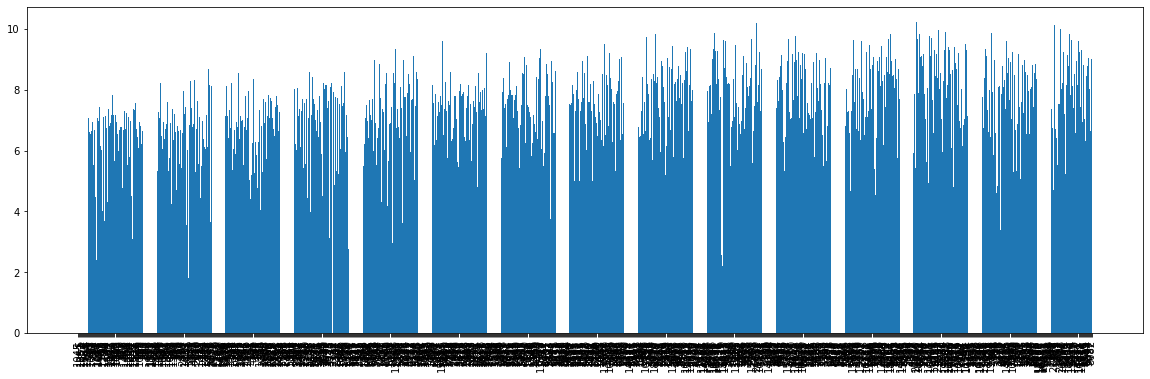

In [ ]:
plt.figure(figsize = (20,6))
plt.bar(UNIQUE[:1000],np.log(unique)[:1000])
plt.xticks(rotation=90)

#for index, value in enumerate(counts[:100]):
    #plt.text(index, value+2000, str(value), horizontalalignment='center', rotation=90)

plt.show()

# Preparing Data for modeling small dataset

In [113]:
temp = df[:1000]
temp

,BROWSE_NODE_ID,CLEANED TEXT,Encoded_BROWSE_NODE_ID
0,0,cat blue doll inch cat popular cat new cat blu...,1
1,1,new refrigerator magnet new cello wrapped hard...,2
2,-1,ultimate self complete guide baking craft gard...,0
3,3,kid iron tablet kid iron tablet quantity tablet,3
4,4,teacher planner company lesson teacher planner...,4
...,...,...,...
1022,40,flying machine men prince slim fit jean blue c...,30
1023,1023,sleepwear boy play well pajama navy blue watch...,522
1024,1024,united color benetton men casual shirt small b...,523
1025,69,bburago diecast motorcycle red bburago diecast...,44


In [115]:
len(temp.Encoded_BROWSE_NODE_ID.value_counts())

524

In [116]:
np.array(temp['CLEANED TEXT'])[0:2]

array(['cat blue doll inch cat popular cat new cat blue doll rock striped red slipper one cat ready measure inch tall safe age removable clothing surface wash new cat blue plush doll based popular cat book super cuddly ready safe age perfect age measure inch',
       'new refrigerator magnet new cello wrapped hard magnet measure inch width inch height highlight one many beautiful new cover full color cat tea cup new cover artist cat tea cup new cover artist cello wrapped hard magnet ideal home office gift new magazine lover highlight one many beautiful new cover full color rigid magnet measure inch width inch height new'],
      dtype=object)

In [16]:
def max_length(series):
  maxlen = 0
  for text in tqdm(series):
    length = len(set(text.split()))    
    if maxlen < length:
      maxlen = length
  return maxlen

In [17]:
max_length(temp['CLEANED TEXT'])

100%|██████████| 10/10 [00:00<00:00, 41775.94it/s]


61

# Tokenizer

In [117]:
tokenizer = Tokenizer()         #oov_token = 'OOV'

In [118]:
tokenizer.fit_on_texts(temp['CLEANED TEXT'])

In [ ]:
dir(tokenizer)

In [20]:
print(tokenizer.document_count)
print(tokenizer.index_docs)
print(tokenizer.index_word)
print(tokenizer.num_words)
print(tokenizer.oov_token)
print(tokenizer.word_counts)
print(tokenizer.word_docs)
print(tokenizer.word_index)

10
defaultdict(<class 'int'>, {113: 1, 44: 1, 104: 1, 105: 1, 110: 1, 42: 1, 16: 2, 116: 1, 45: 2, 43: 1, 111: 1, 109: 1, 28: 2, 103: 1, 29: 1, 6: 2, 5: 3, 115: 1, 107: 1, 112: 1, 108: 1, 106: 1, 7: 2, 27: 1, 114: 1, 15: 2, 52: 1, 53: 1, 122: 1, 55: 2, 118: 1, 117: 1, 120: 1, 54: 1, 47: 1, 32: 2, 50: 1, 30: 2, 11: 2, 17: 1, 33: 2, 18: 1, 51: 1, 46: 1, 48: 1, 119: 1, 121: 1, 31: 2, 49: 1, 124: 1, 128: 1, 130: 1, 126: 1, 127: 1, 125: 1, 131: 1, 129: 1, 123: 1, 12: 2, 34: 1, 56: 1, 132: 1, 13: 3, 57: 1, 58: 1, 134: 1, 136: 1, 135: 1, 133: 1, 60: 1, 137: 1, 138: 1, 20: 1, 59: 1, 140: 1, 139: 1, 35: 2, 19: 1, 61: 2, 157: 1, 165: 1, 153: 1, 143: 1, 72: 1, 21: 1, 171: 1, 141: 1, 149: 1, 156: 1, 176: 1, 159: 1, 174: 1, 147: 1, 142: 1, 162: 1, 1: 3, 64: 1, 22: 3, 163: 1, 164: 1, 67: 1, 151: 1, 152: 1, 172: 1, 63: 1, 144: 1, 70: 1, 66: 1, 68: 1, 37: 3, 173: 1, 166: 1, 155: 1, 167: 1, 148: 1, 65: 1, 169: 1, 158: 1, 62: 1, 168: 1, 71: 1, 69: 1, 161: 1, 175: 1, 9: 1, 146: 1, 150: 1, 154: 1, 170: 1,

In [119]:
 tokenizer.texts_to_matrix(['cat blue flash learning flash'], mode='count')

array([[0., 0., 0., ..., 0., 0., 0.]])

In [120]:
 tokenizer.texts_to_matrix(['cat blue flash learning flash'], mode='count').shape

(1, 4298)

In [121]:
tokenizer.texts_to_sequences(['cat blue flash the learning flash to',
                              'blue amzo'])

[[452, 30, 701, 408, 701], [30]]

In [122]:
tokenizer.sequences_to_texts(tokenizer.texts_to_sequences(['cat blue flash the learning flash to',
                              'blue amzo']))

['cat blue flash learning flash', 'blue']

In [68]:
bow = tokenizer.texts_to_matrix(temp['CLEANED TEXT'], mode='count')
bow.shape

(10, 195)

In [69]:
bow[0]

array([0., 0., 0., 0., 0., 3., 2., 7., 0., 0., 0., 0., 0., 0., 0., 3., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

# Data Generator

In [123]:
class Data_Generator(tf.keras.utils.Sequence):
    """
    Helper function to iterate over the data (as Numpy arrays).
    """
 
    def __init__(self, batch_size, input_text_series, target_label_series):
        self.batch_size = batch_size
        self.input_text_series = input_text_series
        self.target_label_series = target_label_series
 
    def __len__(self):
      '''
      returns the number of batches per epoch.
      '''
      return len(self.input_text_series) // self.batch_size                    # 10//2
 
    def __getitem__(self, index):
        """
        Returns tuple (input, target) correspond to one batch at index.
        """

        iterator = index * self.batch_size                                        # 0*2
                                                          
        x_batch = self.input_text_series[iterator : iterator + self.batch_size]                 # [0: 0+2]
        y_batch = self.target_label_series[iterator : iterator + self.batch_size]             # [0: 0+2]

        x_batch = tokenizer.texts_to_matrix(x_batch, mode='count')
 
        return np.asarray(x_batch), np.asarray(y_batch)

In [124]:
# checking gererator function
batch_size = 32
train_gen = Data_Generator(batch_size,
                           np.array(temp['CLEANED TEXT']),
                           np.array(temp['Encoded_BROWSE_NODE_ID'])
                           )


In [125]:
train_gen.__len__()

31

In [91]:
x, y = train_gen.__getitem__(0)
print(x.shape, y.shape)

Index: 0 iterator: 0
(2, 195) (2,)


In [92]:
x,y

(array([[0., 0., 0., 0., 0., 3., 2., 7., 0., 0., 0., 0., 0., 0., 0., 3.,
         2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 3., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 4., 8., 2., 0., 0., 0., 2., 0., 0., 0., 0.,
         2., 4., 4., 0., 0., 

In [93]:
print(type(x), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [129]:
num_classes = len(temp.Encoded_BROWSE_NODE_ID.value_counts())          #len(le.classes_)
num_classes

524

In [130]:
input_layer = tf.keras.Input(shape=(4298,), dtype="int64")
 
#Dense Layer
x = tf.keras.layers.Dense(128,activation='relu')(input_layer)
x = tf.keras.layers.Dropout(0.2)(x)
 
#Dense Layer
x = tf.keras.layers.Dense(256,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
 
x = tf.keras.layers.Dense(64,activation='relu')(x)
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
 
model = tf.keras.Model(input_layer, output_layer)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4298)]            0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               550272    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_19 (Dense)             (None, 524)               3406

In [131]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
 
model.compile(optimizer=opt,
              loss="sparse_categorical_crossentropy", 
              metrics = 'accuracy')  


In [133]:
start = datetime.now()
 
# Train the model, doing validation at the end of each epoch.
epochs = 10
model_history = model.fit(train_gen, epochs=epochs)
 
end = datetime.now()
print(f'Time take to train {epochs} epochs is:', start - end)

Epoch 1/10
31/31 [==============================] - 0s 8ms/step - loss: 0.8877 - accuracy: 0.8377
Epoch 2/10
31/31 [==============================] - 0s 9ms/step - loss: 0.6261 - accuracy: 0.8962
Epoch 3/10
31/31 [==============================] - 0s 8ms/step - loss: 0.4717 - accuracy: 0.9214
Epoch 4/10
31/31 [==============================] - 0s 8ms/step - loss: 0.3769 - accuracy: 0.9385
Epoch 5/10
31/31 [==============================] - 0s 8ms/step - loss: 0.2885 - accuracy: 0.9677
Epoch 6/10
31/31 [==============================] - 0s 9ms/step - loss: 0.2172 - accuracy: 0.9748
Epoch 7/10
31/31 [==============================] - 0s 9ms/step - loss: 0.1916 - accuracy: 0.9718
Epoch 8/10
31/31 [==============================] - 0s 8ms/step - loss: 0.1743 - accuracy: 0.9718
Epoch 9/10
31/31 [==============================] - 0s 9ms/step - loss: 0.1665 - accuracy: 0.9758
Epoch 10/10
31/31 [==============================] - 0s 8ms/step - loss: 0.1242 - accuracy: 0.9879
Time take to train 

In [138]:
history = model_history.history
history

{'accuracy': [0.8377016186714172,
  0.8961693644523621,
  0.9213709831237793,
  0.9385080933570862,
  0.9677419066429138,
  0.9747983813285828,
  0.9717742204666138,
  0.9717742204666138,
  0.975806474685669,
  0.9879032373428345],
 'loss': [0.8876726031303406,
  0.6261177659034729,
  0.47165706753730774,
  0.3769228458404541,
  0.28846362233161926,
  0.21716000139713287,
  0.19163618981838226,
  0.17434652149677277,
  0.16645680367946625,
  0.12417660653591156]}

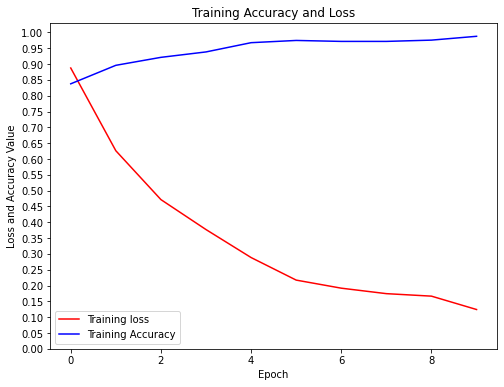

In [142]:
train_loss = history['loss']
train_acc = history['accuracy']

plt.figure(figsize=(8,6))

plt.plot(train_loss, 'r', label='Training loss')
plt.plot(train_acc, 'b', label='Training Accuracy')
plt.title('Training Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss and Accuracy Value')
plt.yticks(np.arange(0, 1.05,.05))
plt.legend()

In [144]:
pred = model.predict(train_gen)
print(type(pred))
print(pred.shape)

<class 'numpy.ndarray'>
(992, 524)


In [147]:
tf.nn.top_k(pred[:5], k = 1)

TopKV2(values=<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.99992824],
       [0.9997855 ],
       [0.99975497],
       [0.98655474],
       [0.9995104 ]], dtype=float32)>, indices=<tf.Tensor: shape=(5, 1), dtype=int32, numpy=
array([[1],
       [2],
       [0],
       [3],
       [4]], dtype=int32)>)

In [146]:
temp['Encoded_BROWSE_NODE_ID'][:5]

0    1
1    2
2    0
3    3
4    4
Name: Encoded_BROWSE_NODE_ID, dtype: int64

# Preparing data for modeling full dataset

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#fit_on_texts

In [ ]:
from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
X = df['CLEANED TEXT']
Y = df['BROWSE_NODE_ID']

print(len(X), len(Y))
print(X[0], Y[0])

2332507 2332507
cat blue doll inch cat popular cat new cat blue doll rock striped red slipper one cat ready measure inch tall safe age removable clothing surface wash new cat blue plush doll based popular cat book super cuddly ready safe age perfect age measure inch 0


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1866005,)
(466502,)
(1866005,)
(466502,)


In [ ]:
del(df)

In [ ]:
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(X_train)

In [ ]:
tokenizer.texts_to_matrix(['cat blue flash learning flash'], mode='count')

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
bow = tokenizer.texts_to_matrix(X_train[0], mode='count')
bow.shape

In [ ]:
c

#NLTK and Gensim

https://radimrehurek.com/gensim/models/word2vec.html

https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [ ]:
import gensim
import gensim.downloader
from gensim.models import KeyedVectors

In [ ]:
#list(gensim.downloader.info()['models'].keys())

In [ ]:
#word2vec_model = gensim.downloader.load('word2vec-google-news-300') 
#word2vec_model.save_word2vec_format('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/model.bin', binary=True)

In [ ]:
#model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/wordvec.bin', binary=True)
#len(model.vocab)

In [ ]:
#!wget https://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
#!unzip /content/glove.6B.zip

In [ ]:
'''# load the whole embedding into memory
glove_embeddings = dict()
f = open('/content/glove.6B.200d.txt')

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(glove_embeddings))'''

"# load the whole embedding into memory\nglove_embeddings = dict()\nf = open('/content/glove.6B.200d.txt')\n\nfor line in tqdm(f):\n    values = line.split()\n    word = values[0]\n    coefs = np.asarray(values[1:], dtype='float32')\n    glove_embeddings[word] = coefs\n\nf.close()\nprint('Loaded %s word vectors.' % len(glove_embeddings))"

In [ ]:
#np.save('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/glove_embeddings.npy', glove_embeddings) 

In [ ]:
glove_embeddings = np.load('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/glove_embeddings.npy',allow_pickle='TRUE').item()
print(len(glove_embeddings)) 

400000


# Modeling

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(X_train)
len(X_train)

70000

In [ ]:
X_val = tf.data.Dataset.from_tensor_slices(X_val)
len(X_val)

30000

In [ ]:
len(X_train)

70000

In [ ]:
len(y_train)

70000

In [ ]:
max_features = 50000  # Maximum vocab size.
max_len = 500  # Sequence length to pad the outputs to.
#embedding_dims = 2

In [ ]:
#vectorize_layer = TextVectorization(max_tokens=max_features, output_sequence_length=max_len)

In [ ]:
#vectorize_layer.adapt(X_train)

In [ ]:
'''import pickle

pickle.dump({'config': vectorize_layer.get_config(),
             'weights': vectorize_layer.get_weights()}
            , open("/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/vectorize_layer.pkl", "wb"))
'''

'import pickle\n\npickle.dump({\'config\': vectorize_layer.get_config(),\n             \'weights\': vectorize_layer.get_weights()}\n            , open("/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/vectorize_layer.pkl", "wb"))\n'

In [ ]:
import pickle
# `config` to create object and 
# `weights` to load the trained weights. 

from_disk = pickle.load(open("/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/vectorize_layer.pkl", "rb"))
vectorize_layer = TextVectorization.from_config(from_disk['config'])

# You have to call `adapt` with some dummy data (BUG in Keras)
vectorize_layer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))

vectorize_layer.set_weights(from_disk['weights'])


In [ ]:
vectorize_layer.get_vocabulary()[:5]

['', '[UNK]', 'material']

In [ ]:
voc = vectorize_layer.get_vocabulary()            #max_features
word_index = dict(zip(voc, range(len(voc))))

print(len(voc))
print(len(word_index))

3
3


In [ ]:
num_tokens = max_features + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 1 words (2 misses)


In [ ]:
embedding_matrix.shape

(50002, 200)

In [ ]:
'''
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    weights=[embedding_matrix],
    trainable=False)
'''

'\nembedding_layer = Embedding(\n    num_tokens,\n    embedding_dim,\n    weights=[embedding_matrix],\n    trainable=False)\n'

In [ ]:
'''
model = Sequential()
 
model.add(keras.Input(shape=(None,), dtype="int64"))
#model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
 
 
#embedding layer
model.add(embedding_layer)
 
#lstm layer
model.add(layers.LSTM(256,return_sequences=True))
model.add(layers.Dropout(0.2))
 
#Global Maxpooling
model.add(layers.GlobalMaxPooling1D())
 
#Dense Layer
model.add(layers.Dense(128,activation='relu')) 
model.add(layers.Dropout(0.2))
 
#Dense Layer
model.add(layers.Dense(128,activation='relu')) 
model.add(layers.Dropout(0.2))
 
model.add(layers.Dense(64,activation='relu')) 
model.add(layers.Dense(number_of_classes,activation='sigmoid'))
 
 
print(model.summary())
'''

'\nmodel = Sequential()\n \nmodel.add(keras.Input(shape=(None,), dtype="int64"))\n#model.add(tf.keras.Input(shape=(1,), dtype=tf.string))\n \n \n#embedding layer\nmodel.add(embedding_layer)\n \n#lstm layer\nmodel.add(layers.LSTM(256,return_sequences=True))\nmodel.add(layers.Dropout(0.2))\n \n#Global Maxpooling\nmodel.add(layers.GlobalMaxPooling1D())\n \n#Dense Layer\nmodel.add(layers.Dense(128,activation=\'relu\')) \nmodel.add(layers.Dropout(0.2))\n \n#Dense Layer\nmodel.add(layers.Dense(128,activation=\'relu\')) \nmodel.add(layers.Dropout(0.2))\n \nmodel.add(layers.Dense(64,activation=\'relu\')) \nmodel.add(layers.Dense(number_of_classes,activation=\'sigmoid\'))\n \n \nprint(model.summary())\n'

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/model_4.h5')
print(model.summary)

ValueError: ignored

In [ ]:
for i in X_train.take(3):
  print(i.numpy())

In [ ]:
for i in X_train.take(1):
  print(i.numpy())

In [ ]:
X_TRAIN = vectorize_layer([i.numpy() for i in X_train])
X_VAL = vectorize_layer([i.numpy() for i in X_val])
 
Y_TRAIN = np.array(y_train)
Y_VAL = np.array(y_val)

In [ ]:
print(X_TRAIN.shape)
print(X_VAL.shape)
print(Y_TRAIN.shape)
print(Y_VAL.shape)

In [ ]:
from keras.optimizers import Adam
opt = Adam()
 
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["acc"])
 
filepath = "/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/model_epoch_{epoch:08d}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only= False)
 
callbacks = [checkpoint]

In [ ]:
for i in range(1,epochs+1):
  model.fit(X_TRAIN, Y_TRAIN, batch_size= 64, epochs=i, validation_data=(X_VAL, Y_VAL))
  try:
    model.save(f'/content/drive/MyDrive/Datasets/Amazon_ML_Challenge/model_{i+4}.h5')
  except:
    pass
  print('Success:',i)

# END